In [1]:
print("hello")

hello


In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import os
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro")

res = llm.invoke("Hello, how are you?")

res.content

"Hello! I'm doing very well, thank you for asking. As an AI, I don't have feelings, but I'm functioning perfectly and ready to help.\n\nHow can I assist you today?"

In [4]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")
vector = embeddings.embed_query("What are embeddings?")
len(vector)

3072

In [5]:
from langchain_community.document_loaders import PyPDFLoader

paths = ["C:\\Users\\SRJ\\SRJ\\Work\\agentic_ai\\Langgraph\\data\\Arihant GK 2025 - Himexam.pdf",  "C:\\Users\\SRJ\\SRJ\\Work\\agentic_ai\\Langgraph\\data\\modern_indian_history_tutorial.pdf"]
docs = []
for path in paths:
    loader = PyPDFLoader(path)
    docs.extend(loader.load())

In [6]:
len(docs)

451

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=25)
doc_splits = text_splitter.split_documents(docs)


In [8]:
len(doc_splits)

11766

In [11]:
from langchain_community.vectorstores import Chroma

vectorstore=Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chrome",
    embedding=embeddings
)

In [12]:
retriever=vectorstore.as_retriever()
retriever.invoke("what is the capital of France?")

[Document(metadata={'creationdate': '2024-09-08T14:34:17+05:30', 'creator': 'Adobe Acrobat Pro (64-bit) 23.1.20064', 'moddate': '2025-03-30T09:49:03+02:00', 'page': 136, 'page_label': '137', 'producer': '3.0.24 (5.1.10)', 'source': 'C:\\Users\\SRJ\\SRJ\\Work\\agentic_ai\\Langgraph\\data\\Arihant GK 2025 - Himexam.pdf', 'title': '', 'total_pages': 160}, page_content='Denmark Copenhagen Krone\nEgypt Cairo Egyptian Pound\nFrance Paris Franc, Euro\nGermany Berlin Euro'),
 Document(metadata={'creationdate': '2024-09-08T14:34:17+05:30', 'creator': 'Adobe Acrobat Pro (64-bit) 23.1.20064', 'moddate': '2025-03-30T09:49:03+02:00', 'page': 136, 'page_label': '137', 'producer': '3.0.24 (5.1.10)', 'source': 'C:\\Users\\SRJ\\SRJ\\Work\\agentic_ai\\Langgraph\\data\\Arihant GK 2025 - Himexam.pdf', 'title': '', 'total_pages': 160}, page_content='Countries with Capitals and Currencies\nCountry Capital Currency\nAfghanistan Kabul Afghani'),
 Document(metadata={'creationdate': '2024-09-08T14:34:17+05:30',

In [14]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool=create_retriever_tool(
    retriever,
    "retriever_GK",
    "Search and return information about General Knowledge and Indian History.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to General Knowledge and Indian History. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",
)

In [15]:
tools=[retriever_tool]

from langgraph.prebuilt import ToolNode

retriever_node=ToolNode(tools)

retriever_node

tools(tags=None, recurse=True, explode_args=False, func_accepts={'config': ('N/A', <class 'inspect._empty'>), 'store': ('store', None)}, tools_by_name={'retriever_GK': Tool(name='retriever_GK', description="Search and return information about General Knowledge and Indian History.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to General Knowledge and Indian History. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.", args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x000001F71969B2E0>, retriever=VectorStoreRetriever(tags=['Chroma', 'GoogleGenerativeAIEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x000001F71960E350>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial

In [16]:
from typing import Annotated,Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

from langchain_core.prompts import PromptTemplate

In [17]:
llm_with_tool=llm.bind_tools(tools)

response=llm_with_tool.invoke("what is LLM Powered Autonomous Agents explain the planning and reflection and prompt engineering explain me in terms of agents and langchain?")

In [18]:
response

AIMessage(content=['Of course! Let\'s break down these concepts in the context of LLM-powered autonomous agents, specifically focusing on how LangChain helps build them.\n\n### What are LLM-Powered Autonomous Agents?\n\nThink of an autonomous agent as a smart computer program that can pursue a goal on its own. The "brain" of this program is a Large Language Model (LLM) like GPT-4.\n\nInstead of just responding to a single prompt, an agent uses the LLM to **reason, plan, and execute a series of actions** to achieve a complex objective. It\'s the difference between asking a calculator "What is 2+2?" and telling a personal assistant "Plan a weekend trip to Paris for me."\n\nThe agent\'s core loop looks like this:\n1.  **Goal:** Receives a high-level goal from the user.\n2.  **Think:** The LLM "thinks" about what it needs to do first.\n3.  **Act:** It chooses a **tool** (like a web search, a calculator, or a database query) and uses it.\n4.  **Observe:** It gets the result (observation) fr

In [19]:
def LLM_Decision_Maker(state:AgentState):
    print("----CALL LLM_DECISION_MAKE----")
    message=state["messages"]
    last_message=message[-1]
    question=last_message.content
    response=llm_with_tool.invoke(question)
    return {"messages":[response]}

In [20]:
from langchain_core.pydantic_v1 import BaseModel, Field

class grade(BaseModel):
    binary_score:str=Field(description="Relvance score 'yes' or 'no'")

c:\Users\SRJ\SRJ\Work\agentic_ai\venv\Lib\site-packages\IPython\core\interactiveshell.py:3699: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [21]:
from typing import Literal
#we use it for type of hinting

def grade_documents(state:AgentState)->Literal["Output Generator", "Query Rewriter"]:
    print("----CALLING GRADE FOR CHECKING RELEVANCY----")
    llm_with_structure_op=llm.with_structured_output(grade)
    
    prompt=PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant. 
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                    )
     
    chain=prompt|llm_with_structure_op
     
    message=state['messages']
    
    last_message = message[-1]
    
    question = message[0].content
    
    docs = last_message.content
    
    scored_result=chain.invoke({"question": question, "context": docs})
    
    score=scored_result.binary_score
     
    if score=="yes":
        print("----DECISION: DOCS ARE RELEVANT----")
        return "generator"
    else:
        print("----DECISION: DOCS ARE NOT RELEVANT----")
        return "rewriter"

In [22]:
from langchain import hub

hub.pull("rlm/rag-prompt").pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [23]:
def generate(state:AgentState):
    print("----RAG OUTPUT GENERATE----")
    
    message=state["messages"]
    question=message[0].content
    
    last_message = message[-1]
    docs = last_message.content
    
    prompt=hub.pull("rlm/rag-prompt")
    
    rag_chain=prompt | llm
    
    response=rag_chain.invoke({"context": docs, "question": question})
    
    print(f"this is my response:{response}")
    
    return {"messages": [response]}
    

In [ ]:
def rewrite(state:AgentState):
    print("----TRANSFORM QUERY----")
    message=state["messages"]
    
    question=message[0].content
    
    input= [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: {question} 
                    Formulate an improved question: """)
       ]

    response=llm.invoke(input)
    
    return {"messages": [response]}

In [25]:
from langgraph.graph import END, StateGraph, START

workflow=StateGraph(AgentState)

workflow.add_node("LLM Decision Maker",LLM_Decision_Maker)
workflow.add_node("Vector Retriever",retriever_node)
workflow.add_node("Output Generator",generate)
workflow.add_node("Query Rewriter",rewrite)

workflow.add_edge(START,"LLM Decision Maker")

from langgraph.prebuilt import tools_condition

workflow.add_conditional_edges("LLM Decision Maker",
                               tools_condition,
                               {"tools":"Vector Retriever",
                                END:END
                                })

workflow.add_conditional_edges("Vector Retriever",
                               grade_documents,
                               {"generator":"Output Generator",
                                "rewriter":"Query Rewriter"
                                })

workflow.add_edge("Output Generator",END)

workflow.add_edge("Query Rewriter","LLM Decision Maker")

app=workflow.compile()

import warnings
warnings.filterwarnings("ignore")

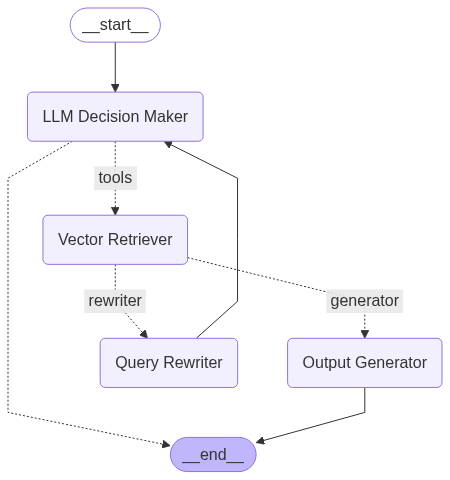

In [26]:
app

In [31]:
app.invoke({"messages":["how do you think is the work of narendra modi so far?"]})

----CALL LLM_DECISION_MAKE----


{'messages': [HumanMessage(content='how do you think is the work of narendra modi so far?', additional_kwargs={}, response_metadata={}, id='e17c3456-245d-435e-ad88-38642f6f6c53'),
  AIMessage(content="The work of Narendra Modi's government has been a subject of widespread discussion and debate, with a range of views on its impact. Here’s a look at some of the key areas and the different perspectives on them:\n\n**Economic Policies:**\n*   **Goods and Services Tax (GST):** Supporters say it has simplified the tax structure and improved efficiency. Critics point to initial implementation challenges and the complexity of the multi-slab system.\n*   **Make in India:** This initiative aims to boost domestic manufacturing. It has seen some success in sectors like electronics, but its overall impact on job creation is debated.\n*   **Demonetisation:** The government stated its goals were to curb black money, counterfeit currency, and terrorism financing. The move was highly controversial, wit